# Описание задачи

**Cookie cats** - многоуровневая игра из категории "три в ряд" или "кристаллики", завернутая в сюжет приключений кошек, ворвавшихся на фабрику печенья.

В игре есть стоповый элемент - достигая каждый 30й уровень, игрок теряет на некоторое время возможность играть, но можно оплатить проход внутриигровой валютой. *Цель нововведения* - привлечь больше аудитории посредством перемещения стопового элемента - ключа - *с 30 уровня на 40*.

Чтобы отследить динамику поведения пользователей без серьёзных потерь со стороны заказчика в случае неудачи, мы проводим эксперимент, развёрнутый на часть аудитории с последующим разделением на две равные группы - контрольную и тестовую - без нововведения и с ним соответственно.

Выделив ключевые метрики и сравнив их поведение между группами, мы сможем заключить - удачен эксперимент или нет. Благодаря чему, своевременно развернув нововведение на всех пользователей в виде обновления игры (в случае удачного эксперимента), получим большую прибыль с ростом аудитории. Если эксперимент окажется неудачным, то мы потеряем только часть аудитории из тестовой группы, удержав уровень прибыли от падения и отказавшись от нововведения.

## Извлечение данных, определение функций

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import sqlite3
import io
import scipy
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from statsmodels.stats.power import TTestIndPower
from scipy import stats

In [2]:
# построение графика на два распределения

def hists (samp1, samp2, txt1='', txt2='', title=''):
    sns.set(rc={'figure.figsize':(12,5)})
    sns.histplot(samp1, color = '#00140b', alpha = 0.7, label = txt1, edgecolor='#004524')
    sns.histplot(samp2, color = '#ff2957', alpha = 0.6, label = txt2, edgecolor='#ff2957')
    plt.xlabel('')
    plt.legend(fontsize = 13)
    plt.title(title, fontsize = 15)
    plt.show()
 

In [3]:
# Построение двух отдельных гистограм в одном контейнере

def subplot_hists(samp_control, samp_test):

    sns.set(rc={'figure.figsize':(14,6)})
    fig, axes = plt.subplots(1, 2)
    sns.histplot(samp_control, ax = axes[0], color = '#013220').set_title('Контрольная группа')
    sns.histplot(samp_test, ax=axes[1], color = '#013220').set_title('Тестовая группа')
    fig.show()


In [4]:
# Извлекаем данные

url = 'https://raw.githubusercontent.com/TashaStrogaya/fileshub/main/cookie_cats.csv'
df = pd.read_csv(url, sep =',')

Поля, описывающие возваращаемость пользователя на следующий день и через неделю заданы как булевые переменные. Для анализа переведём их на значения ноль - false - и единица - true.

In [5]:
df['ret_1'] = np.where(df['retention_1'] == True, 1, 0)
df['ret_7'] = np.where(df['retention_7'] == True, 1, 0)

Группы для теста подобраны одного объема.

Разобъём исходный датафрейм на два для групп А и В, удалив неактуальные колонки retention_1, retention_7, version.

In [6]:
df_control, df_target = df[df.version == 'gate_30'].reset_index(), df[df.version == 'gate_40'].reset_index()

In [7]:
df_control = df_control.drop(['retention_1', 'retention_7', 'version'], axis=1)
df_target = df_target.drop(['retention_1', 'retention_7', 'version'], axis=1)

# Предварительный анализ

In [8]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,ret_1,ret_7
0,116,gate_30,3,False,False,0,0
1,337,gate_30,38,True,False,1,0
2,377,gate_40,165,True,False,1,0
3,483,gate_40,1,False,False,0,0
4,488,gate_40,179,True,True,1,1


В инетресах бизнеса увидеть, что пользователь проводит больше времени в его приложении и приносит этим больше прибыли. И все нововведения должны соотвествовать этим целям.

Поэтому *нулевую гипотезу* я возьму как - нововведения не повлияло на вовзращаемость пользователя. *Альтерантивная гипотеза* - нововведение изменило возвращаемость пользователя.

Чтобы подтвердить или опровергнуть НО **будут использованы метрики**:
* ret_7 - *возвращаемость пользователя на 7 день*
* ret_1 - *возвращаемость пользователя на 1 день*
* sum_gamerounds - *общее время проведенное в игре* (сумма сыгранных раундов)

Основная метрика - ret_7, т.к. она отображает перешл ли пользователь в статус постоянного.

In [9]:
df.groupby('version', as_index = False).size()

,version,size
0,gate_30,44700
1,gate_40,45489


Объём групп одного порядка, что повышает чувствительность теста.

In [10]:
# рассчитаем MDE
analysis = TTestIndPower()
print(f"В нашем тесте - {analysis.solve_power(power = 0.8, nobs1=df_control.size, ratio=df_target.size / df_control.size, alpha=0.05) * 100:.2f}% - минимально обнаруживаемый эффект" + \
        " с мощностью 1-b = 0.8 и уровнем значимости a=0.05 на заданных размерах выборок.")

В нашем тесте - 0.83% - минимально обнаруживаемый эффект с мощностью 1-b = 0.8 и уровнем значимости a=0.05 на заданных размерах выборок.


Посмотрим статистику групп А и В по вовзращаемости на первый и седьмой дни **retention_1, retention_7**.

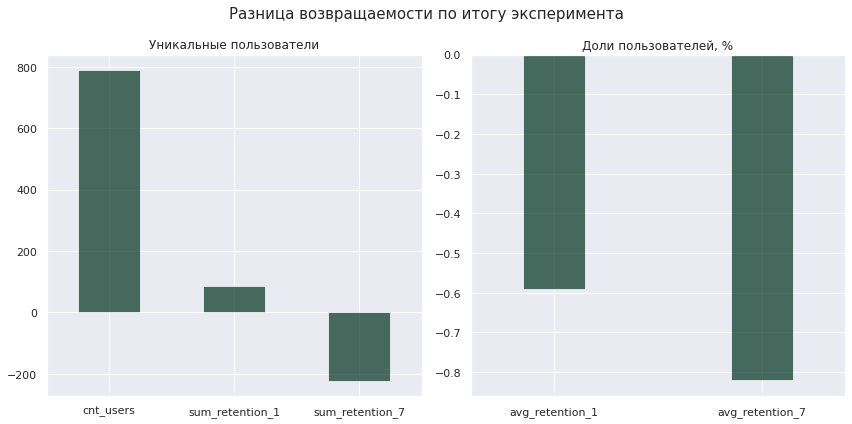

In [11]:
df_agg = df.groupby('version').agg(cnt_users = ('userid', 'nunique'), \
                                            sum_retention_1 = ('ret_1', 'sum'), avg_retention_1 = ('ret_1', 'mean'), \
                                            sum_retention_7 = ('ret_7', 'sum'), avg_retention_7 = ('ret_7', 'mean'))
df_agg= df_agg.append((df_agg.iloc[1] - df_agg.iloc[0]), ignore_index=True)
df_agg['version'] = ['gate_30', 'gate_40', 'diff']
df_agg = df_agg[['version','cnt_users',	'sum_retention_1',	'avg_retention_1',	'sum_retention_7'	,'avg_retention_7']]
df_agg.avg_retention_1 *= 100
df_agg.avg_retention_7 *= 100

sns.set(rc={'figure.figsize':(12,6)})
plt.suptitle('Разница возвращаемости по итогу эксперимента', fontsize=15)
plt.subplot(1,2,1)
df_agg[['cnt_users', 'sum_retention_1', 'sum_retention_7']].iloc[-1].plot(kind = 'bar', color='#013220', rot = 0, alpha=0.7)
plt.title('Уникальные пользователи')
plt.subplot(1,2,2)
df_agg[['avg_retention_1', 'avg_retention_7']].iloc[-1].plot(kind = 'bar', color='#013220', rot = 0, width=0.3, alpha=0.7)
plt.title('Доли пользователей, %')
plt.tight_layout()
plt.show()

Начальный объем пользователей в target группе, прирост по объему вернувшихся в 1 день есть, то т.к. объем группы 40к пользователй, то он незначительный. На 7 день наблюдаем деградацию относитлеьно conrol группы.

Для наглядности посмотрим на относительные значения. Доля оставшихся пользователей от нулевого дня на первый день сократилась на ~0.6%, на 7 день - на ~0,8%. Что предаврительно говорит о негативном результате. Но возможно разница случайна, для выяснения необходимо провести тестирование между группами по этим параметрам.

Перейдём к следующей метрики - сыгранные раунды **sum_gamerounds**.

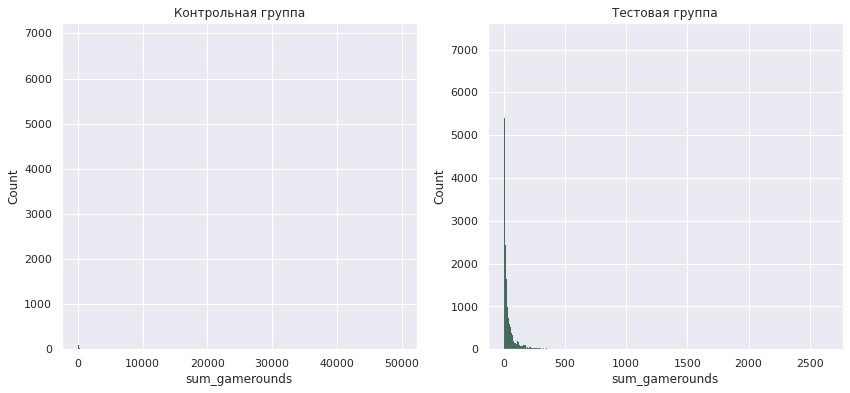

In [12]:
subplot_hists(df_control.sum_gamerounds, df_target.sum_gamerounds)

Распределение положительно ассимтрисное, у контрольной группы хвост слишком вытянут, поэтому на график выведем данные с *усечением по 2500*.

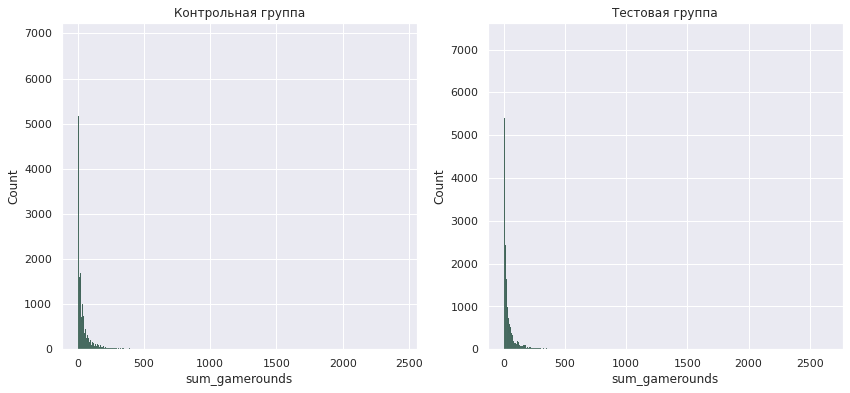

In [13]:
subplot_hists(df_control.query('sum_gamerounds < 2500').sum_gamerounds, df_target.sum_gamerounds)

In [14]:
print(f"{df_control.sum_gamerounds.var():.3f} - Дисперсия control группы\n{df_target.sum_gamerounds.var():.3f} - Дисперсия target группы")

65903.322 - Дисперсия control группы
10669.736 - Дисперсия target группы


Распределения вида sum_gamerounds пркитчески не поддаются визуальному анализу из-за сильной дисперсии, поэтому для её анализа необходимо использовать методы с ранжированием или с трансформацией метрики. В части с АВ-тестированием я приведу в пример оба метода.

# AB-test

Чтобы иметь математические доаказательства принятия решения по поводу развития продукта мы проведем стат. тесты на всех метриках.

Для *вовзращаемости* я буду использовать Пуасоновский бустрап, т.к. доля вернувшихся на N день пользователей - это глобальная метрика. Благодаря бутсрапу мы получим симуляцию 2000 тестов и распределение долей возвращаемости пользователей в каждом из них. Использование Пуассоновского распределения упростит вычисления и значительно ускорит симуляции, тк мы не генерируем каждый раз выборку, а рассчитываем, сколько раз в выборку попадет каждый представитель.

Для *сыгранных раундов* я использую несколько методов: 
* Трансформация метрики с помощью взятия логарифма. С его использованием значительно уменьшится дисперсия, т.е. повысится чувствительность теста.
* Использование децилей. Я разобью распределение на 10 равных групп в зависимости от количества сыгранных раундов. И в каждой группе проведу стат.тест.
* Классический U-test Манна-Уитни. Т.к. он использует ранжирование, то вид распределения для него не является стоппером. 

Уровень значимости 0,05, мощность 0,8.

## Определение функций

In [15]:
# функция расчёта p_value двух выборок тестом Манна-Уитни
def t_mann (samp1, samp2):
    p_val = stats.mannwhitneyu(
        samp1, samp2,
        alternative = 'two-sided')[1]
    
    print(f'Тест Манна-Уитни дал p_value = {p_val}')
    print(f'Нулевая гипотеза отвергается, выборки принадлежат разным ГС' if p_val < 0.05 else f'Нулевая гипотеза принимается, выборки принадлежат одной ГС')
    
    return p_val

In [16]:
# функция расчёта p_value для двух выборок Т-тестом

def t_test (samp1, samp2):
    p_val = stats.ttest_ind(samp1, samp2,
                equal_var=False)[1]
    
    print(f'Т-тест Стьюдента дал p_value = {p_val}')
    print(f'Нулевая гипотеза отвергается, выборки принадлежат разным ГС' if p_val < 0.05 else f'Нулевая гипотеза принимается, выборки принадлежат одной ГС')
    
    return p_val

In [17]:
# функция Пуассоновского бутстрапа

def poisson_bootstrap(metric1, metric2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(metric1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(metric2))).astype(np.int64)
    
    boot_metric1 = (poisson_bootstraps1*metric1).mean(axis=1)
    boot_metric2 = (poisson_bootstraps2*metric2).mean(axis=1)
    
    return boot_metric1, boot_metric2

In [18]:
# функция вывода распределения разниц и границами, исполбьзуется после бустрапа

def hist_boost (samp, title='', set_bins = 50):
    sns.set(rc={'figure.figsize':(12,5)})
    samp_mean = samp.mean()
    sigma = 1.96 * samp.var() / len(samp)**0.5
    
    plt.axvline(x = 0, color='#ff033e', linewidth=2) # визуальная проверка на включение в разницу нуля
    
    plt.gca().add_patch(Rectangle(
        (np.quantile(samp, 0.05/2), 0),
        np.quantile(samp, 1-0.05/2)-np.quantile(samp, 0.05/2),
        len(samp)/10,
        edgecolor = 'black',
        facecolor = 'pink',
        alpha = 0.4,
        label='ДИ 95%',
        fill=True
    ))
    
    sns.histplot(samp, color = '#013220', alpha=0.6, label='Разница')
    plt.title(title, fontsize = 15)
    plt.legend()
    plt.show()
    

In [19]:
# Функция создания графика по децилям с помощью Пуасоновского бутстрапа. Вовзращает границы ДИ и дисперсию в каждом дециле

def decile_analyze(df_control, df_target):
    max_vals = []
    min_vals = []
    var_vals = {'control': [], 'target' : []}
    labels = [str(i) for i in range(1,11)]

    sns.set(rc={'figure.figsize':(21,14)})

    for i, ind in enumerate(labels):
        control_ind = df_control[df_control.quantiles_label == ind].sum_gamerounds.to_numpy()
        target_ind = df_target[df_target.quantiles_label == ind].sum_gamerounds.to_numpy()
        rounds_control, rounds_target = poisson_bootstrap(control_ind, target_ind)

        plt.subplot(4, 3, i+1)
        sns.histplot(data=rounds_control, color = '#00140b', alpha = 0.8, label = 'control')
        sns.histplot(data=rounds_target, color = '#ff0033', alpha = 0.6, label = 'target').set_title(ind + ' дециль', fontweight='bold')
        plt.legend()

        var_vals['control'].append(round(rounds_control.var(), 3))
        var_vals['target'].append(round(rounds_target.var(), 3))

        diff = rounds_control - rounds_target
        max_vals.append(np.quantile(diff, 0.05/2))
        min_vals.append(np.quantile(diff, 1 - 0.05/2))

    plt.subplot(4, 3, 11)
    plt.hlines(y=labels[:-3], xmin=min_vals[:-3], xmax=max_vals[:-3], linewidth=4, color='#004524')
    plt.axvline(x = 0, color='#ff033e', linewidth=1)
    plt.title('ДИ 95% разницы средних квантилей 1-7', fontweight='bold')
    plt.subplot(4, 3, 12)
    plt.hlines(y=labels[-3:], xmin=min_vals[-3:], xmax=max_vals[-3:], linewidth=4, color='#004524')
    plt.axvline(x = 0, color='#ff033e', linewidth=1)
    plt.title('ДИ 95% разницы средних квантилей 8-10', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return min_vals, max_vals, var_vals

## Метрика Sum_gamerounds

### U-test manna-whitney

Тест Манна-Уитни определит, принадлежат ли выборки к одной генеральной совокупности.

In [20]:
p_val = t_mann(df_control.sum_gamerounds, df_target.sum_gamerounds)

Тест Манна-Уитни дал p_value = 0.05020880772044255
Нулевая гипотеза принимается, выборки принадлежат одной ГС


НО отвергается, но p_value близка к критическому значению. Поэтому для надежности необходимо проввести допольнительные тесты.

### Трансформация через log(метрики)

Наше  исходное распредлеение похоже на эксоненциальное, поэтому обратная экспоненте функция уменьшит дисперсию и сделает распределение удобночитаемым.
Описательные статистики нельзя применять к нашему распределению, то соотношение средних сохранится после трансформации. И дальнейший стат. тест будет уже сравнивать не распределения, а их эффект.

2.245 - Дисперсия control группы
2.278 - Дисперсия target группы


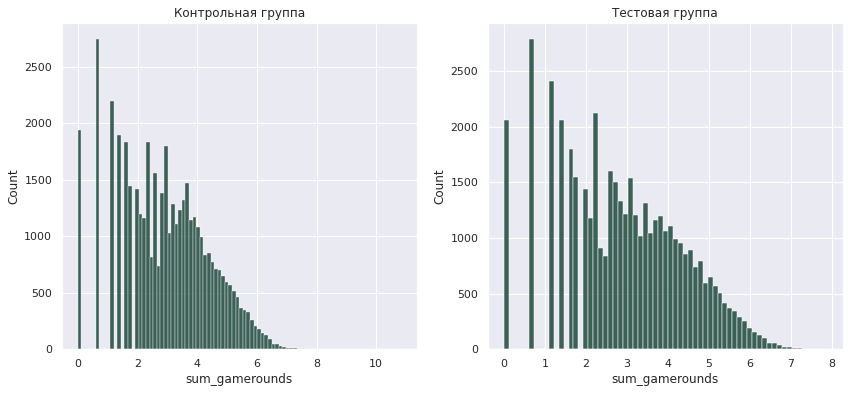

In [21]:
log_control = np.log(df_control.sum_gamerounds + 1)
log_target = np.log(df_target.sum_gamerounds + 1)

subplot_hists(log_control, log_target)
print(f"{log_control.var():.3f} - Дисперсия control группы\n{log_target.var():.3f} - Дисперсия target группы")

In [22]:
print(f"Соотношение средних control и target:\n{df_target.sum_gamerounds.mean()/df_control.sum_gamerounds.mean():.2f} - начальная метрика")
print(f"{log_target.mean()/log_control.mean():.2f} - логарифмированная метрика")

Соотношение средних control и target:
0.98 - начальная метрика
0.99 - логарифмированная метрика


Мы получили псевдонормальное распределение (только правая часть похожа), поэтому для надежности применим метод Пуассоновского Бутстрапа.

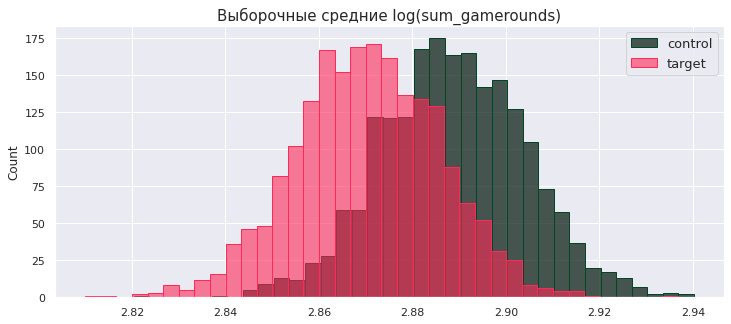

In [23]:
boot_control, boot_target = poisson_bootstrap(log_control.to_numpy(), log_target.to_numpy())
hists(boot_control, boot_target, 'control', 'target', 'Выборочные средние log(sum_gamerounds)')

Распределения достаточно плотно накладываются друг на друга, посмотрим на их разницу.

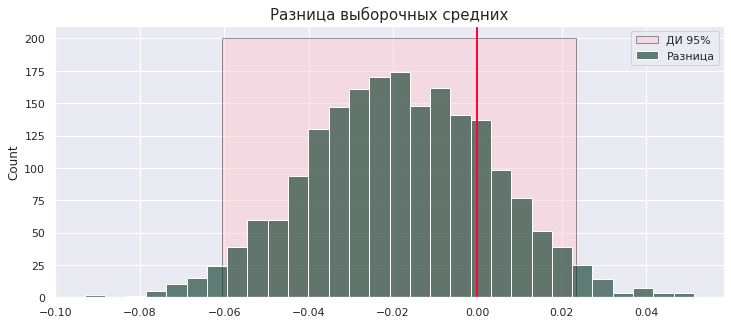

Дисперсия = 0.00047, Среднее = -0.01840


In [24]:
hist_boost(boot_target - boot_control, 'Разница выборочных средних')
print(f'Дисперсия = {(boot_target - boot_control).var():.5f}, Среднее = {(boot_target - boot_control).mean():.5f}')

ДИ включает ноль, поэтому изменения не статзначимы. НО принимается, также как и по манна-уитни.

Метрика логарифмов получилась псевдонормальная, но интересно, что покажет в данном случае т-тест.

In [25]:
t_test (log_control, log_target)

Т-тест Стьюдента дал p_value = 0.06964323357674272
Нулевая гипотеза принимается, выборки принадлежат одной ГС


0.06964323357674272

Т-тест также подтвердил НО и p_value уже дальше от порога, чеи при u-тесте на исходном распределении.

### Разбиенеие по децилям

Разбиение по децилям создаст 10 групп с низкой дисперсией, тк они подобраны по общему признаку - близкое значение sum_gamerounds. После чего на каждом рсаспределении проведем Пуассоновский бустрап и посмотрим на эффект в разных группах.

In [26]:
# Разбиваем на децили

df_control['quantiles'] = pd.qcut(df_control.sum_gamerounds, q=10, precision=0)
df_target['quantiles'] = pd.qcut(df_target.sum_gamerounds, q=10, precision=0)

In [27]:
# Даем децилям лейбл

labels = [str(i) for i in range(1,11)]
df_control['quantiles_label'] = pd.qcut(df_control.sum_gamerounds, q=10, precision=0, labels=labels)
df_target['quantiles_label'] = pd.qcut(df_target.sum_gamerounds, q=10, precision=0, labels=labels)

Создадим датафрейм как справочник разбияния.

In [28]:
df_qcut = pd.DataFrame({'decile' : labels,
                        'control' : df_control['quantiles'].unique().sort_values(),
                        'target' : df_target['quantiles'].unique().sort_values()})

Использовав функцию опредленную раннее decile_analyze, постром графики бутстрап-распредлений и их доверительных интервал значимости 95% для их разниц. Описатльные статистики границ ДИ и дисперсий сложим в соотвсествующие переменные.

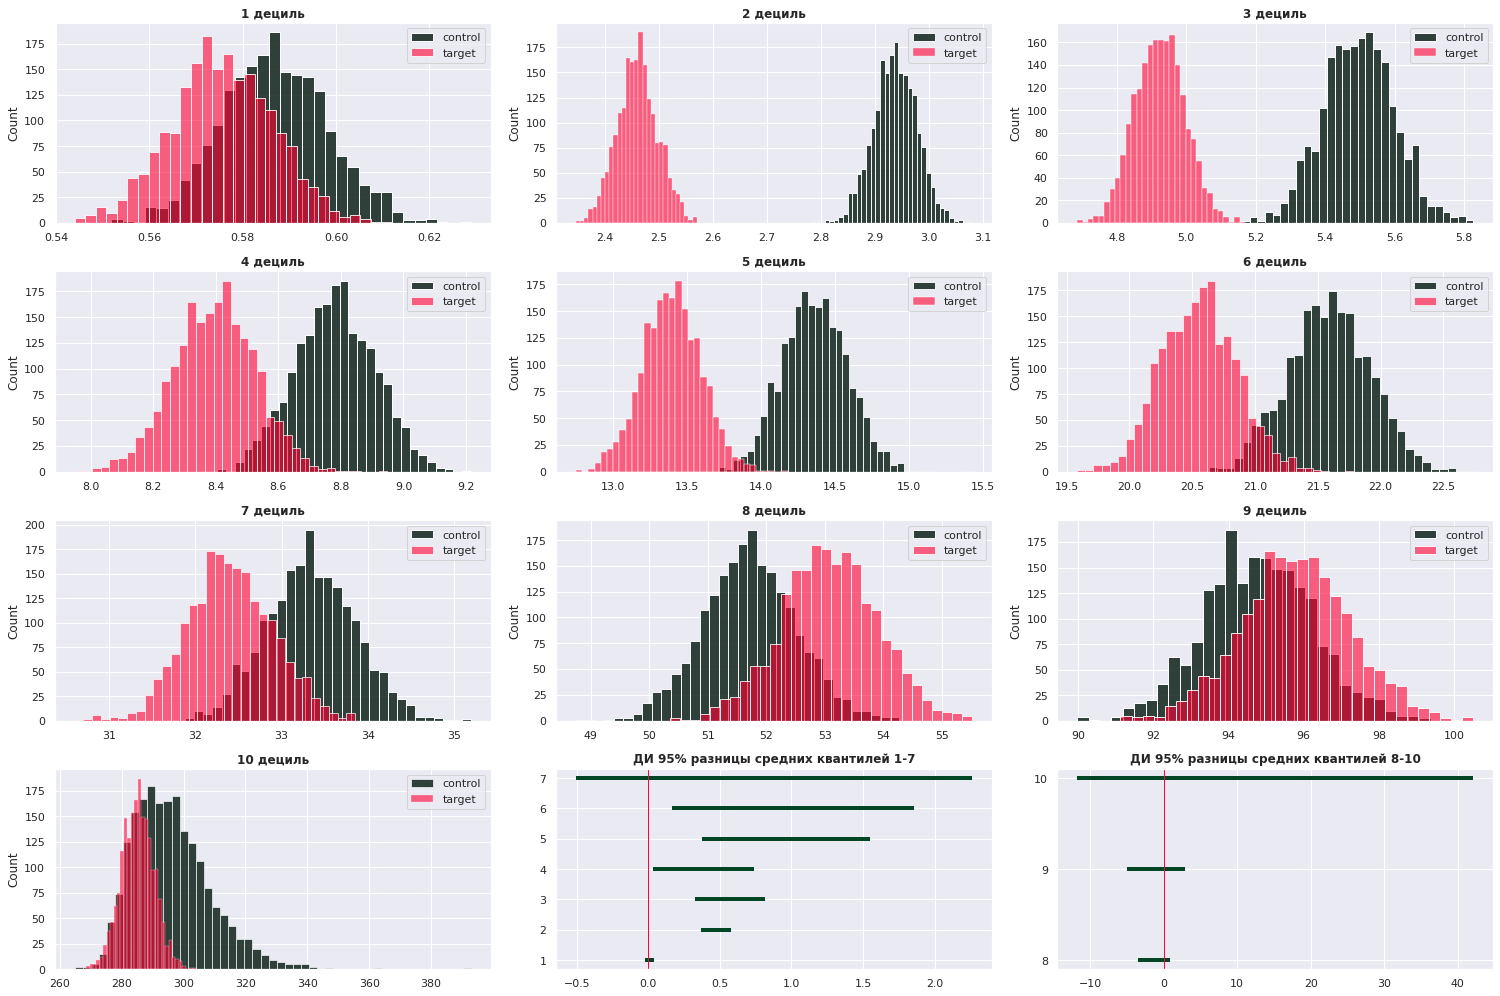

In [29]:
min_vals, max_vals, var_vals = decile_analyze(df_control, df_target)

In [30]:
print(f"Полученные дисперсии:\n{var_vals}")

Полученные дисперсии:
{'control': [0.0, 0.002, 0.011, 0.016, 0.048, 0.108, 0.261, 0.618, 2.051, 160.23], 'target': [0.0, 0.001, 0.005, 0.017, 0.04, 0.09, 0.245, 0.66, 2.108, 27.783]}


Дисперсия выросла только в 10 группе, что ожидалось для распределений с длинным хвостом.

Три теста дали нестат значимые результаты и приняли НО. При распределении на децили мы получили такие же результаты для 1, 7-10 децилей и стат значимые негативные результаты для 2-6 децилей. Вероятно из-за этого расхождения p_value в u-тесте был близок к порогу.

Пользователи децилей 2-6 стали значимо меньше играть. Эти пользователи за время эксперимента сыграли от 1 до 40 игр. Возможно, с отодвиганием замка с 30 на 40 у них упала мотивация, тк дистанция до первого финиша стала дальше.

Посмотреть на таблицу границ децилей можно ниже. Колонка mid_per_global_mean% показывает долю середины интервала дециля от среднего по сыгранным ранудам.

In [31]:
control_mean = df_control.sum_gamerounds.mean()
target_mean = df_target.sum_gamerounds.mean()

df_qcut['mid_per_global_mean_control'] = df_qcut.control.apply(lambda x: round(x.mid / control_mean , 2))
df_qcut['mid_per_global_mean_target'] = df_qcut.target.apply(lambda x: round(x.mid / target_mean , 2))
df_qcut = df_qcut[['decile', 'control', 'mid_per_global_mean_control', 'target', 'mid_per_global_mean_target']]
df_qcut

,decile,control,mid_per_global_mean_control,target,mid_per_global_mean_target
0,1,"(-1.0, 1.0]",0.00,"(-1.0, 1.0]",0.00
1,2,"(1.0, 4.0]",0.05,"(1.0, 3.0]",0.04
2,3,"(4.0, 6.0]",0.10,"(3.0, 6.0]",0.09
3,4,"(6.0, 11.0]",0.16,"(6.0, 10.0]",0.16
4,5,"(11.0, 17.0]",0.27,"(10.0, 16.0]",0.25
5,6,"(17.0, 26.0]",0.41,"(16.0, 25.0]",0.40
6,7,"(26.0, 40.0]",0.63,"(25.0, 40.0]",0.63
7,8,"(40.0, 66.0]",1.01,"(40.0, 68.0]",1.05
8,9,"(66.0, 135.0]",1.92,"(68.0, 134.0]",1.97
9,10,"(135.0, 49854.0]",476.48,"(134.0, 2640.0]",27.04


Нулевая гипотеза по 3/4 тестов принимается. Тест с разбиенем по децилям показал, что для пользователй, которые мало играют, изменпения имели стат значимо негативный характер.

## Retention

Главаная метрика игр - возвращаемость пользователя. Если игра ему понравится, то он будет вовзращаться и отдавать свои деньги или время бизнесу. В нашей игре время - это тоже деньги, те игра мобильная и ее основной доход - просмотры рекламы.

Вовзращаемость мы будем смотреть с помощью Пуассоновского бутстрапа.

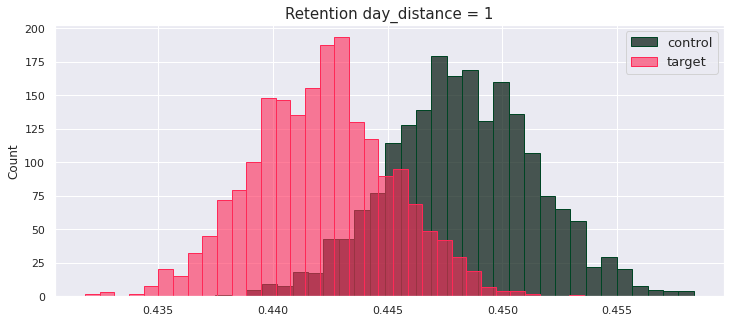

In [32]:
control_ret_1, target_ret_1 = poisson_bootstrap(df_control.ret_1.to_numpy(), df_target.ret_1.to_numpy())
hists(control_ret_1, target_ret_1, 'control', 'target', 'Retention day_distance = 1')

Распределения почти накладываются друг на друга. Посмотрим их разницу.

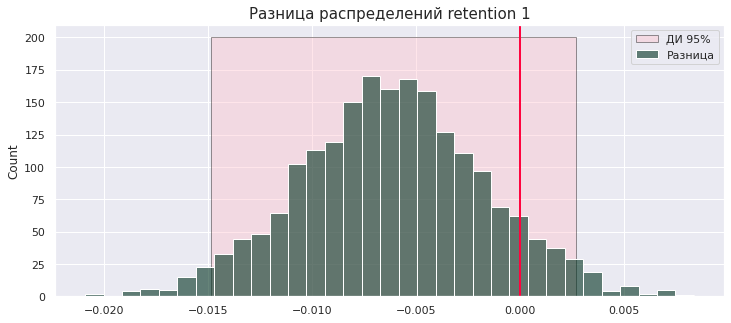

Дисперсия = 0.00002, Среднее = -0.00614


In [33]:
hist_boost(target_ret_1-control_ret_1, 'Разница распределений retention 1')
print(f'Дисперсия = {(target_ret_1 - control_ret_1).var():.5f}, Среднее = {(target_ret_1 - control_ret_1).mean():.5f}')

ДИ интервал разницы распределений включает ноль, поэтому мы принимаем H0 - стат значимых изменеий нет.

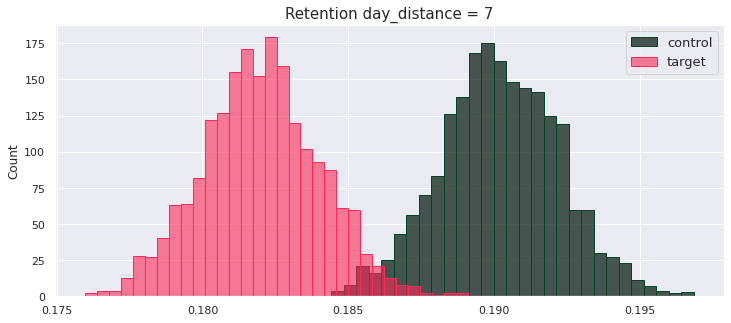

In [34]:
control_ret_7, target_ret_7 = poisson_bootstrap(df_control.ret_7.to_numpy(), df_target.ret_7.to_numpy())
hists(control_ret_7, target_ret_7, 'control', 'target', 'Retention day_distance = 7')

В этот раз распределния значитлеьно расходятся. Посмотрим на их разницу.

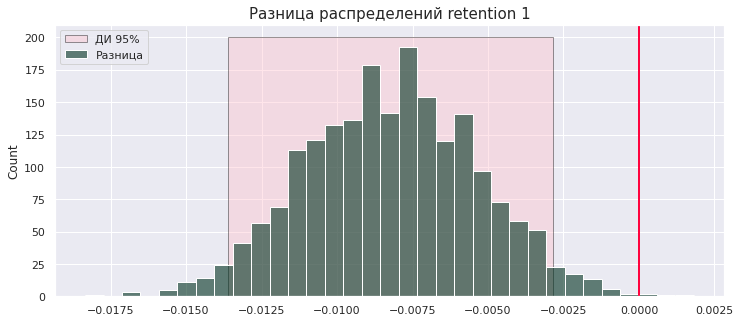

Дисперсия = 0.00001, Среднее = -0.00819


In [35]:
hist_boost(target_ret_7 - control_ret_7, 'Разница распределений retention 1')
print(f'Дисперсия = {(target_ret_7 - control_ret_7).var():.5f}, Среднее = {(target_ret_7 - control_ret_7).mean():.5f}')

ДИ интервал разницы не включает ноль. Изменения стат значимы и негативны (разница отрицательна). НО отвергается.

# Выводы

Основная метрика - retention_7 - вовзращаемость на 7 день дала стат.значимо негативный результат, поэтому я бы не стала выкатывать изменения на всех пользователей.

Также малоиграющие пользователи стали значимо меньше проводить времени за игрой. По крупным игрокам изменений нет. Вовзращаемость на 1 день также значимо не изменилась.